<a href="https://colab.research.google.com/github/simonsobs/pixell_tutorials/blob/master/pixell_map_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map Manipulation with pixell


*Written by the ACT Collaboration*

---

This  notebook, and the accompanying notebooks included in this set, are designed to help users who are new to working with [`pixell`](https://github.com/simonsobs/pixell/) get started with the package. As a set these notebooks will guide users through examples of how to read in and display maps, how to perform spherical harmonic transform and calculate simple spectra, how to transform the maps and how to study point sources in the maps.

The `pixell` library allows users to load,
manipulate and analyze maps stored in rectangular pixelization. It is
mainly targeted for use with maps of the sky (e.g. CMB intensity and polarization maps, stacks of 21 cm intensity maps, binned galaxy positions or shear) in cylindrical projection.

In this introductory notebook we will explain the basis for the sky maps used in `pixell` and walk through examples of how to read in CMB maps and inspect them. We'll also explain how to relate the pixels to locations on the sky and how to inspect smaller patches of the sky.

In [1]:
# Import packages
from pixell import enmap, utils, enplot
import numpy as np
import healpy as hp
%matplotlib widget

## About `pixell` and `ndmap` objects

The `pixell` library supports manipulation of sky maps that are represented as 2-dimensional grids of rectangular pixels. The supported projection and pixelization schemes are a subset of the schemes supported by FITS conventions. In addition, we provide support for a *plain* coordinate system, corresponding to a Cartesian plane with identically shaped pixels (useful for true flat-sky calculations).

In `pixell`, a map is encapsulated in an `ndmap`, which combines two objects: a numpy array (of at least two dimensions) whose two trailing dimensions correspond to two coordinate axes of the map, and a `wcs` object that specifies the World Coordinate System. The `wcs` component is an instance of Astropy’s `astropy.wcs.wcs.WCS` class. The combination of the wcs and the shape of the numpy array completely specifies the footprint of a map of the sky, and is called the `geometry`. This library helps with manipulation of `ndmap` objects in ways that are aware of and preserve the validity of the wcs information.

The `wcs` information describes the correspondence between celestial coordinates (typically the Right Ascension, or RA, in the Equatorial system) and the pixel indices in the two right-most axes. In some projections, such as CEA or CAR, rows (and columns) of the pixel grid will often follow lines of constant declination (and RA). In other projections, this will not be the case.

The WCS system is very flexible in how celestial coordinates may be associated with the pixel array. By observing certain conventions, we can make life easier for users of our maps. We recommend the following:

The first pixel, index [0,0], should be the one that you would normally display (on a monitor or printed figure) in the lower left-hand corner of the image. The pixel indexed by [0,1] should appear to the right of [0,0], and pixel [1,0] should be above pixel [0,0]. (This recommendation originates in FITS standards documentation.)
When working with large maps that are not near the celestial poles, RA should be roughly horizontal and declination should be roughly vertical. (It should go without saying that you should also present information “as it would appear on the sky”, i.e. with RA increasing to the left!)
The examples in the rest of this document are designed to respect these two conventions.

### Creating an `ndmap`

We can define an `ndmap` by using `pixell` to specify a geometry. For example, if we want to create an empty map we would do the following:



In [2]:
# Define area of map using numpy
# pixell wants the box in the following format:
# [[dec_from, RA_from], [dec_to, RA_to]]
# Note RA goes "from" left "to" right!
box = np.array([[-5, 10], [5, -10]]) * utils.degree

# Define a map geometry
# the width and height of each pixel will be .5 arcmin
shape, wcs = enmap.geometry(pos=box, res=0.5 * utils.arcmin, proj='car')

# Create an empty ndmap
empty_map = enmap.zeros((3,) + shape, wcs=wcs)

## Inspecting maps

The `ndmap` class extends the `numpy.ndarray` class, and thus has all of the usual attributes (`.shape`, `.dtype`, etc.) of an `ndarray`. It is likely that an `ndmap` object can be used in any functions that usually operate on an ndarray; this includes the usual numpy array arithmetic, slicing, broadcasting, etc.

An `ndmap` must have at least two dimensions. The two right-most axes represent celestial coordinates (typically declination and RA, respectively). Maps can have arbitrary number of leading dimensions, but many of the `pixell` CMB-related tools interpret 3D arrays with shape `(ncomp,Ny,Nx)` as representing `Ny` x `Nx` maps of intensity, polarization Q and U Stokes parameters, in that order.

In [3]:
# Check out the ndmap
# does the shape make sense given the bounding box and resolution?
print(empty_map.shape)
print(empty_map.dtype)
print(empty_map + np.pi)
print(empty_map[0, 10:15, 90:95] == 0)

(3, 1200, 2400)
float64
ndmap([[[3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  ...
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]]

 [[3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  ...
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
  [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]]

 [[3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14

The `ndmap` also has a new attribute, the `wcs`:

In [4]:
print(empty_map.wcs)

car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[1201.00,601.00]}


It has everything we need to map pixels to and from the sky: the cylindrical projection we are using (`car`), the size of the pixels (in degrees), the location on the sky of a reference pixel (in degrees) and the location in the array of the reference pixel.

NOTE: the `ndmap` data contains declination in the second-to-last axis and RA in the last axis, because this corresponds to the varying rows and columns of the array. But in the `wcs`, which is built by `astropy` outside of `pixell`, information is stored in the opposite order: RA first, then declination. Note the size of the pixels in RA is negative: the RA of pixels farther to the right in the array is *less*.

We can also add a wcs to a numpy array. Sometimes this is necessary after performing a numpy operation on a ndmap as it might remove the `wcs`:

In [ ]:
stacked_map = np.concatenate([empty_map, empty_map])

print(stacked_map.shape)
print(stacked_map.wcs)

Let's fix this:

In [5]:
# Let's add a wcs to this data by doing this
omap = enmap.ndmap(stacked_map, wcs)

# Or this
omap = enmap.samewcs(stacked_map, empty_map)

# This does the same thing, but force-copies the data array.
omap = enmap.enmap(stacked_map, wcs)

NameError: name 'stacked_map' is not defined

Note that `ndmap` and `samewcs` will not copy the underlying data array if they don’t have to; the returned object will reference the same memory used by the input array (as though you had done `numpy.asarray`). In contrast, `enmap.enmap` will always create a copy of the input data.

## Reading a map from disk

An entire map in `FITS` or `HDF` format can be loaded using `read_map`, which is found in the module `pixell.enmap`. The `enmap` module contains the majority of map manipulation functions.

In [2]:
imap = enmap.read_map('../../lenps_data/act_planck_dr5.01_s08s18_AA_f150_night_map_d56_I.fits')
print(imap.shape)

(1416, 6426)


Alternatively, one can select a rectangular region specified through its bounds using the box argument,

In [3]:
dec_min = -7 ; ra_min = 5 ; dec_max = 3 ; ra_max = -5

# All coordinates in pixell are specified in radians
box = np.array([[dec_min, ra_min], [dec_max, ra_max]]) * utils.degree

imap_box = enmap.read_map("../../lenps_data/act_planck_dr5.01_s08s18_AA_f150_night_map_d56_I.fits", box=box)
print(imap_box.shape)

(1200, 1200)


We can perform computations on the array like any other array:

In [9]:
print(np.mean(imap))

56.189888


## Visualizing maps

We can use the `pixell.enplot` functions to visualize ndmaps. For example, if we want to plot this imap_box we first create the plot and then show it. This can also be done with a saved map on the command line (i.e. `enplot map_name.fits`). There are several plotting options built-in to the `enplot` function. They are listed in the documentation here: https://pixell.readthedocs.io/en/latest/reference.html#module-pixell.enplot

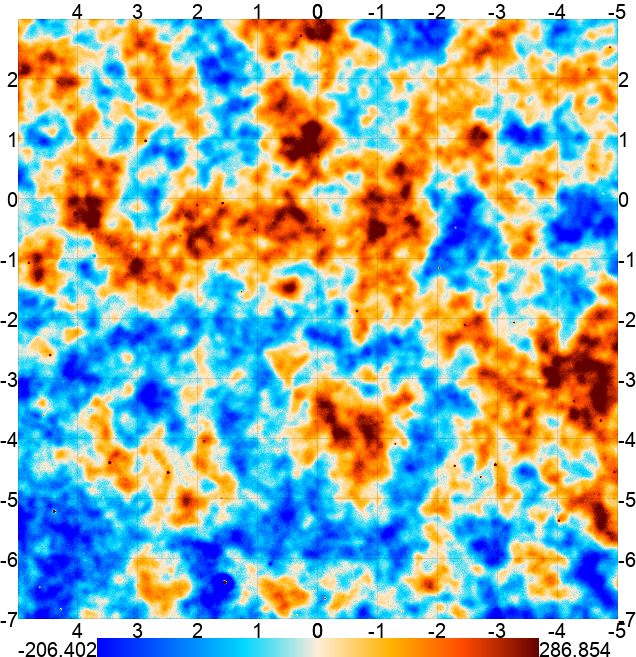

In [4]:
# Code to plot maps
enplot.pshow(imap_box, colorbar=True, downgrade=2)

### Selecting regions of the sky

We may select a region of this map using array slicing. Note that wcs information is correctly adjusted when the array is sliced; for example the object returned by `imap[:50,:50]` is a view into the `imap` data attached to a new `wcs` object that correctly describes the footprint of the extracted pixels. BUT be cautious when assigning an extracted map to a new variable as operations on that variable will also affect the original map.


Original Shape: (1416, 6426), Original WCS: car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397.00,906.00]}
New Shape: (50, 50), New WCS: car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3347.00,856.00]} 



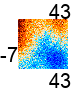

Original Mean: 56.18988800048828
Mean after modification: 60987.56640625


In [5]:
# view one section of the map. Note that wcs is updated
print(f'Original Shape: {imap.shape}, Original WCS: {imap.wcs}')
imap_extract = imap[50:100,50:100]
print(f'New Shape: {imap_extract.shape}, New WCS: {imap_extract.wcs} \n')

# Visualize the map cut out
plot = enplot.plot(imap_extract)
enplot.show(plot)

# note that opperations on imap_extract also affects imap
print(f'Original Mean: {np.mean(imap)}')
imap_extract *= 1e6
print(f'Mean after modification: {np.mean(imap)}')

# Let's get the imap back to it's original state
imap = enmap.read_map('../../lenps_data/act_planck_dr5.01_s08s18_AA_f150_night_map_d56_I.fits')

Alternatively, We can select a coordinate box to creat a subplot around by defining the bottom left and top right coordinates. This opperation will also output the correct wcs for the submap. For example, if we want to create a 0.5x0.5 deg submap around the coordinates a RA of 5 and a DEC of -1 we would use the code below. Note that changing the submap will not affect the original map.

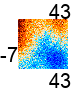

(1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397.00,906.00]}
(120, 120) car:{cdelt:[0.008333,0.008333],crval:[15.47,0],crpix:[1317.00,181.00]} 

56.189888
56.189888


In [12]:
# First we need to define our coordinates and radius in radians (utils.degree converts degrees to radians)
ra = 5. * utils.degree
dec = -1. * utils.degree
radius = 0.5 * utils.degree

# Next we create our submap by defining a box in coordinate space
imap_sub = imap.submap([[dec - radius, ra - radius], [dec + radius, ra + radius]])

# Visualize the map corner
plot = enplot.plot(imap_extract)
enplot.show(plot)

# Note that the shape and wcs are updated
print(imap.shape, imap.wcs)
print(imap_sub.shape, imap_sub.wcs, '\n')

# Opperations on the submap do not affect the mean map
print(np.mean(imap))
imap_sub *= 1e6
print(np.mean(imap))

## Downgrading

`enmap.downgrade` downgrades maps by an integer factor by averaging pixels. We can also downgrade by different integer factors in either direction.

In [13]:
# Using enmap.downgrade, careful with quadrature
# TODO: What do you mean careful with qudrature?

# Downgrade both directions by a factor of 2
imap_downgrade = imap.downgrade(2)
print(imap_downgrade.shape)

# Downgrade in y by 2 and in x by 3
imap_downgrade = imap.downgrade((2, 3))
print(imap_downgrade.shape)

(708, 3213)
(708, 2142)


## Relating pixels to the sky

The geometry specified through `shape` and `wcs` contains all the information to get properties of the map related to the sky. `pixell` always specifies the Y coordinate first. So a sky position is often in the form `(dec,ra)` where `dec` could be the declination and `ra` could be the RA in radians in the equatorial coordinate system.

The pixel corresponding to ra=8, dec=2 can be obtained like

In [14]:
dec = 2
ra = 8
coords = np.deg2rad(np.array((dec,ra)))
ypix, xpix = enmap.sky2pix(imap.shape, imap.wcs, coords)
print(ypix, xpix)

1145.0000000000946 4292.000000004358


We can also use the map directly to perform this calculation:

In [15]:
ypix, xpix = imap.sky2pix(coords)
print(ypix, xpix)

1145.0000000000946 4292.000000004358


We can pass a large number of coordinates for a vectorized conversion. In this case coords should have the shape (2,Ncoords), where Ncoords is the number of coordinates you want to convert, with the first row containing declination and the second row containing RA. For instance,

In [16]:
dec = np.array([-5, 0, 3])
ra = np.array([5, 0, -5])

coords = np.deg2rad(np.array((dec,ra)))
print(coords.shape, '\n')

ypix, xpix = imap.sky2pix(coords)
print(ypix, xpix)

(2, 3) 

[ 305.  905. 1265.] [4652. 5252. 5852.]


Let's find the values of the map at these positions. Most of the work is done, but we must convert each position to an integer value as the returned pixel coordinates are in general fractional.

In [18]:
ypix = ypix.astype(int)
xpix = xpix.astype(int)
imap[ypix, xpix]

array([-127.11344 ,   24.789095,  -49.9626  ], dtype=float32)

Similarly, pixel coordinates can be converted to sky coordinates

In [19]:
ypix = 100
xpix = 100
pixes = np.array([ypix, xpix])
dec, ra = np.rad2deg(imap.pix2sky(pixes)) # pix2sky, sky2pix work in radians
print(dec, ra)

-6.708333333330651 42.93333333335569


Using the `enmap.posmap` function, you can get a map of shape `(2,Ny,Nx)` containing the coordinate positions in radians of each pixel of the map.

In [20]:
posmap = imap.posmap()
dec = posmap[0] # dec in radians
ra = posmap[1] # ra in radians
print(dec[0][0], ra[0][0])

-0.13162691442118638 0.7638724359565692


Using the `enmap.pixmap` function, you can get a map of shape `(2,Ny,Nx)` containing the integer pixel coordinates of each pixel of the map.

In [21]:
pixmap = imap.pixmap()
pixy = pixmap[0]
pixx = pixmap[1]
print(pixy[1][0], pixx[0][1])

1 1


## Exercise: stacking on clusters (based on [this notebook](https://github.com/ACTCollaboration/DR4_DR5_Notebooks/blob/master/Notebooks/Section_4_visualize_objects.ipynb); see also [this notebook](https://github.com/ACTCollaboration/DR6_Notebooks/blob/main/ACT_DR6_ymap_stacking.ipynb) later in the course!)

We will apply what we've learned to do a common analysis technique with our ACT data: stacking maps on galaxy clusters. We might want to do this in order to learn about the gas distribution in and around clusters, or to tease out their mass from weak lensing. To do this we will need a catalogue of cluster locations and more ACT data:

In [24]:
# this is a full ACT DR5 map, downgraded so that it doesn't take up too much
# memory
!curl act_planck_dr5.01_s08s18_AA_f150_night_map_dg_I.fits https://phy-act1.princeton.edu/public/zatkins/act_planck_dr5.01_s08s18_AA_f150_night_map_dg_I.fits

# this is the ACT DR5 tSZ cluster catalogue...how did we make it??
!wget https://astro.ukzn.ac.za/~mjh/ACTDR5/v1.0b3/DR5_cluster-catalog_v1.0b3.fits

zsh:1: command not found: wget


In [22]:
import astropy.table as atpy

# get the map
imap = enmap.read_map('act_planck_dr5.01_s08s18_AA_f150_night_map_dg_I.fits')

# Read in ras and decs from a cluster catalog
tab = atpy.Table().read('DR5_cluster-catalog_v1.0b3.fits', format='fits')

# convert them to radians
ras = tab['RADeg'] * utils.degree
decs = tab['decDeg'] * utils.degree

print(ras.shape, decs.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'act_planck_dr5.01_s08s18_AA_f150_night_map_dg_I.fits'

What does the full ACT DR5 + Planck data look like? Here we are only using the temperature data, not polarization:

In [ ]:
enplot.pshow(imap, downgrade=8, colorbar=True, ticks=15, range=300)

Notice the bright band of the milky way galaxy cutting across the edge of the map. It's not on the equator because the ACT data is natively in celestial coordinates (we can play around with this later). The rest of the blobby pattern, with blobs that are about a degree in size, is the CMB!

Let's cut out a pixel of size .5 degrees around a random cluster and take a look:

In [ ]:
# try this for a bunch of different cluster indexes!
n = 128
radius = 0.5 * utils.degree

imap_sub = imap.submap([[decs[n] - radius, ras[n] - radius], [decs[n] + radius, ras[n] + radius]])

enplot.pshow(imap_sub, upgrade=16, colorbar=True, grid=False)

Not a whole lot there? This is why a stack makes sense: if clusters generally look similar in the map, but their signal is very faint, we can average their locations and try to beat-down the noise. What is the source of "noise" in this case?

In [ ]:
stack = 0
num = 0
for n in range(len(decs)):
  stack += imap.submap([[decs[n] - radius, ras[n] - radius], [decs[n] + radius, ras[n] + radius]])
  num += 1

  if n % 500 == 0: print(f'We have done {n} clusters')

In [ ]:
enplot.pshow(stack/num, upgrade=16, colorbar=True, grid=False)

Nice! Clusters do kind of look the same in the map: they look like a cold spot. Why?

Notice anything else weird about the average cluster, maybe about it's shape? Does this make sense to you? Why or why not?